# Tensorflow API 框架

如下图所示，TensorFlow提供了包含多个API层的编程堆栈：


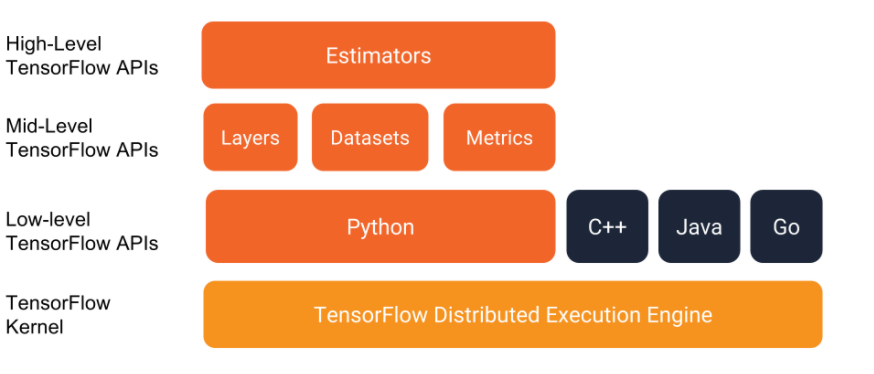


开始编写Tensorflow程序时，强烈建议关注一下两个高级API：
- Estimators
- Datasets

# Tensorflow程序编写流程

- 加载并解析数据集
- 定义特征及标签
- 选择模型算法
- 训练模型
- 评估模型
- 通过模型进行预测

## 加载并解析数据集
Iris 需要下面两个 .csv 文件：
- http://download.tensorflow.org/data/iris_training.csv, 训练集
- http://download.tensorflow.org/data/iris_test.csv, 测试集

In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10

TRAIN_URL        = "http://download.tensorflow.org/data/iris_training.csv"
TEST_URL         = "http://download.tensorflow.org/data/iris_test.csv"
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
                    'PetalLength', 'PetalWidth', 'Species']

def load_data(label_name="Species"):
    """解析CSV文件"""
    
    # 下载训练集
    train_path = tf.keras.utils.get_file(fname=TRAIN_URL.split('/')[-1],
                                         origin=TRAIN_URL)
    # train_path: ~/.keras/datasets/iris_training.csv
    
    # 解析训练集
    train = pd.read_csv(filepath_or_buffer=train_path,
                       names=CSV_COLUMN_NAMES, # 定义列名 
                       header=0) # 忽略第一行
    # 训练集现在已经被加载到DataFrame中
                        
    # 定义训练集特征列和标签列（最后一列 "Species"）
    train_features, train_label = train, train.pop(label_name)
    
    # 同样方式构造测试集
    test_path = tf.keras.utils.get_file(fname=TEST_URL.split('/')[-1],
                                        origin=TEST_URL)
    test = pd.read_csv(filepath_or_buffer=test_path,
                       names=CSV_COLUMN_NAMES,
                       header=0)
    test_features, test_label = test, test.pop(label_name)
    
    return (train_features, train_label), (test_features, test_label)

Keras是开源的机器学习库，tf.keras是Tensorflow基于Keras的实现。**tf.keras.utils.get_file**方法用于下载文件。

In [67]:
# 调用load_data方法
(train_features, train_label), (test_features, test_label) = load_data()

查看训练集特征集

In [68]:
train_features

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3
...,...,...,...,...
115,5.5,2.6,4.4,1.2
116,5.7,3.0,4.2,1.2
117,4.4,2.9,1.4,0.2
118,4.8,3.0,1.4,0.1


查看训练集标签集
标签集包含3个分类，代表Iris的三个物种
- 0：represents setosa
- 1：represents versicolor
- 2：represents virginica

In [24]:
train_label

0      2
1      1
2      2
3      0
4      0
      ..
115    1
116    1
117    0
118    0
119    1
Name: Species, Length: 120, dtype: int64

## 数据描述
特性列是一个数据结构，它告诉您的模型如何解释每个特性中的数据。在Iris的问题中，我们希望模型将每个特性中的数据解释为其字面量的浮点值;也就是说，我们想让模型解释一个输入值，比如4。4。然而，在其他机器学习问题中，通常需要更少地解释数据。  
  
从代码上来说，可以使用**tf.feature_column**来构建特征列。每一个对象被描述为模型的输入。为了让模型将数据解释为浮点型，需要调用**tf.feature_column.numeric_column**

In [26]:
def construct_feature_columns(input_features):
    """构建特征列"""
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

## 选择模型算法
我们需要选择一个算法来对模型进行训练。有许多的算法可供选择，选择理想的算法需要一定的经验。这里选择神经网络算法来解决Iris问题。神经网络可以在特征和标签之间找到复杂的关系。神经网络是一个高度结构化的图形，被组织成一个或多个隐藏层。每个隐藏层由一个或多个神经元组成。神经网络有几种分类。这里使用全连接神经网络，这意味着一层的神经元接受来自上一层的每个神经元的输入。例如，下图演示了一个全连接神经网络，它由三个隐藏层组成：
- 第一个隐藏层包含4个神经元
- 第二个隐藏层包含3个神经元
- 第三个隐藏层包含2个神经元
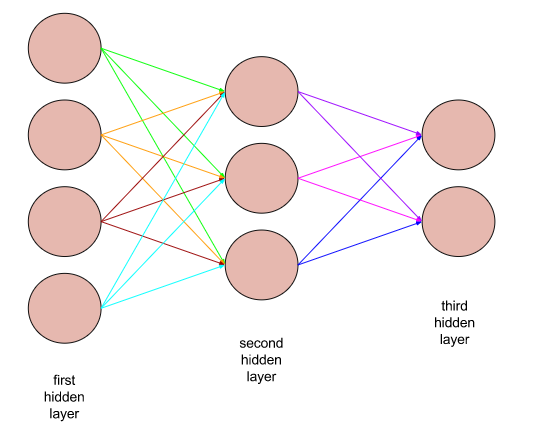

要制定算法模型，需要实例化一个**Estimator**类。Tensorflow 提供了两类Estimator：
- 预制的Estimator，已经封装好的算法
- 自定义的Estimator，自己写算法实现
  
为了实现神经网络，这里使用预制的Estimator，tf.estimator.DNNClassfier

In [147]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=construct_feature_columns(train_features),
    hidden_units=[10, 10], # 2个隐藏层，每个隐藏层包含10个神经元
    n_classes=3 # 3个分类
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_keep_checkpoint_max': 5, '_service': None, '_session_config': None, '_save_checkpoints_secs': 600, '_is_chief': True, '_log_step_count_steps': 100, '_task_type': 'worker', '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_id': 0, '_save_checkpoints_steps': None, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B074F162B0>, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_model_dir': 'C:\\Users\\ADMINI~1\\AppData\\Local\\Temp\\tmpn4q6rob4', '_num_ps_replicas': 0, '_tf_random_seed': None}


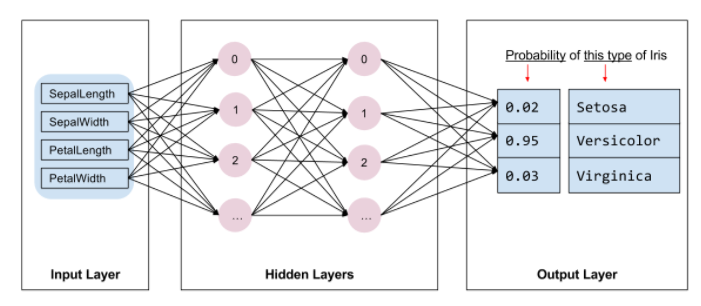

tf.estimator.DNNClassifier的构造函数中还有一个配置参数叫**optimizer**，用来控制如何训练模型。

## 训练模型

实例化**tf.estimator.DNNClassfier**创建了一个学习模型的框架。基本上我们已经拥有了一个神经网络，但是还没有数据进行训练。为了训练神经网络，调用模型的**train**方法

In [148]:
classifier.train(
    input_fn=lambda: train_input_fn(train_features, train_label, 100),
    steps=1000 # 指定迭代训练次数后停止
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ADMINI~1\AppData\Local\Temp\tmpn4q6rob4\model.ckpt.
INFO:tensorflow:loss = 147.40399, step = 1
INFO:tensorflow:global_step/sec: 810.84
INFO:tensorflow:loss = 10.781451, step = 101 (0.123 sec)
INFO:tensorflow:global_step/sec: 1231.29
INFO:tensorflow:loss = 36.33553, step = 201 (0.081 sec)
INFO:tensorflow:global_step/sec: 1312.31
INFO:tensorflow:loss = 25.139359, step = 301 (0.077 sec)
INFO:tensorflow:global_step/sec: 1385.2
INFO:tensorflow:loss = 3.5341725, step = 401 (0.072 sec)
INFO:tensorflow:global_step/sec: 1366.22
INFO:tensorflow:loss = 2.6950383, step = 501 (0.073 sec)
INFO:tensorflow:global_step/sec: 1385.21
INFO:tensorflow:loss = 12.931109, step = 601 (0.072 sec)
INFO:tensorflow:global_step/

**steps**是一个可以进行调优的超参数。与直觉相反，训练一个模型的时间越长，就越不能保证模型更优。  
**input_fn**是输入参数，用来定义如何提供数据。

In [61]:
def train_input_fn(features, labels, batch_size):
    """
    训练输入函数
    paramters
    features: 特征向量
    labels: 标签向量
    batch_size: 训练规模，一个批次样本数量
    """
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    ds = ds.batch(batch_size).repeat().shuffle(buffer_size=1000)
    
    return ds.make_one_shot_iterator().get_next()

train_input_fn依赖**Dataset API**，它用于读取数据并转换为train方法所需要的形式。  
**tf.data.Dataset.shuffle**：将batch_size设置为大于样本数量的值，以确保数据能被很好的打乱。
在训练期间，train方法通常会多次处理样本。调用**tf.data.Dataset.repeat**方法，不传参数，将保证train方法有无限的训练样本。
  
train方法每次处理一批样本。**tf.data.Dataset.batch**方法通过连接多个样本来创建一批样本。该例子中将默认batch_size设置为100，意味着每一批次有100个样本数据。根据经验，较小的批次规模会更快的训练模型，但是有时会降低精度。

**ds.make_one_shot_iterator().get_next()**将返回一批样例

## 评估模型

评估意味着确定模型做出预测的有效程度。为了确定Iris分类模型的有效性，传递一些特征值，并让其做出预测。然后将预测结果与实际标签进行比较。如果预测正确一半，那么精度就是0.5。下面是个更好的模型：
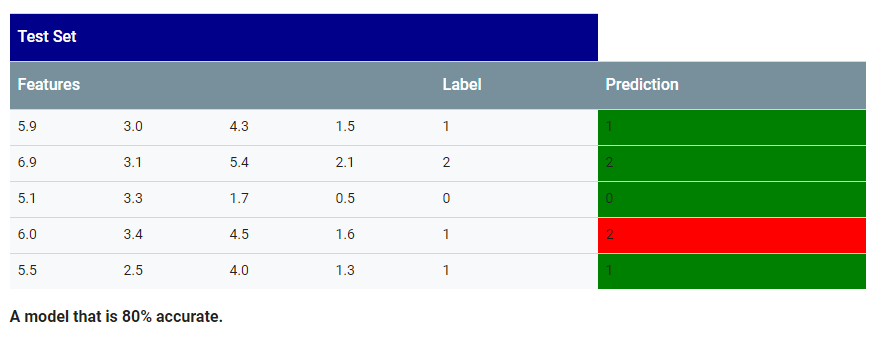

为了评估模型，每个estimator都提供了**evaluate**方法。

In [77]:
# 评估模型
eval_result = classifier.evaluate(
    input_fn=lambda: eval_input_fn(test_features, test_label, 100))

print("\nTest set accuracy: {accuracy:0.3f}\n".format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-21-07:28:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ADMINI~1\AppData\Local\Temp\tmpa0w_rvql\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-21-07:28:54
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.93333334, average_loss = 0.06960806, global_step = 1000, loss = 2.0882418

Test set accuracy: 0.933



调用classifier.evaluate类似于调用classifier.train。最大的不同是，评估必须从测试集中获取样例，而不是训练集。

In [76]:
def eval_input_fn(features, labels=None, batch_size=None):
    """评估输入函数"""
    features = dict(features)
    if labels is None:
        # 没有标签，就仅使用特征
        inputs = features
    else:
        inputs = (features, labels)
    
    # 将输入转换为tf.dataset对象
    ds = tf.data.Dataset.from_tensor_slices(inputs)
    
    # 样例分批
    assert batch_size is not None, "batch_size must not be None"
    ds = ds.batch(batch_size)
    
    # 返回一批样例
    return ds.make_one_shot_iterator().get_next()

## 预测

前面已经训练了一种模型，并且在评估时，验证了模型的精度达到了0.9。现在，我们用训练的模型对未标记的样例做一些预测。也就是说样例只有特征没有标签。

现实中，未标记的样例可能来自多种不同的渠道，包括应用程序，CSV文件和数据库。现在，我们手动构造三个未标记的样例：

In [142]:
predict_features = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.3, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1]
}

每个Estimator也提供了predict方法

In [143]:
predictions = classifier.predict(
    input_fn=lambda: eval_input_fn(predict_features, batch_size=100))

和评估方法一样，预测方法同样也通过eval_input_fn来接收样例。

在做预测是，不会把标签传递给eval_input_fn。因此eval_input_fn会做以下操作：
1. 将3个样例的特征进行转换
2. 创建一批样例
3. 为predict方法返回一批样例

predict方法返回一个python迭代，为每个样例生成一个字典类型的预测结果。这个字典包括许多keys。probabilities 键中有一个三个浮点值的列表，每一个值代表该样例是特定类型的概率。  
如下面的返回值：

**'probabilities': array([  1.19127117e-08,   3.97069454e-02,   9.60292995e-01])**

- 该Iris被认为是Setosa的可能性可以被忽略
- 该Iris被认为是Versicolor的可能性为3.97%
- 该Iris被认为是Virginica的可能性为96.0%

**class_id** 指明了该样例最可能的分类类别，如：  
'class_ids': array([2])  
数字2代表为Virginica分类，下面的代码对返回的预测结果进行迭代，以报告每个预测：

In [140]:
expected = ['Setosa', 'Versicolor', 'Virginica']

for pred_dict, expec in zip(predictions, expected):
    template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')
    
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]
    print(template.format(expected[class_id], 100 * probability, expec))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ADMINI~1\AppData\Local\Temp\tmpa0w_rvql\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediction is "Setosa" (99.9%), expected "Setosa"

Prediction is "Versicolor" (97.0%), expected "Versicolor"

Prediction is "Virginica" (96.8%), expected "Virginica"
